In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re

In [5]:
fake_data = pd.read_csv('./Fake.csv')
real_data = pd.read_csv('./True.csv')

In [7]:
fake_data.isnull().sum()
real_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
fake_data.subject.unique()
real_data.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [9]:
fake_data.drop(['date', 'subject'], axis=1, inplace=True)
real_data.drop(['date', 'subject'], axis=1, inplace=True)
fake_data['class'] = 0 
real_data['class'] = 1

Difference in news articles: 2064


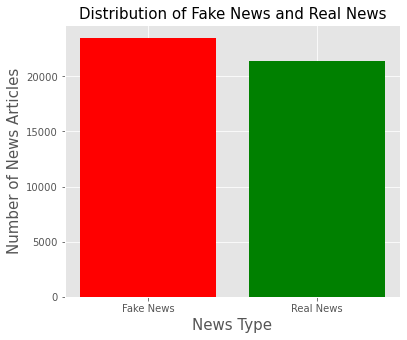

In [46]:
plt.figure(figsize=(6, 5))
plt.bar('Fake News', len(fake_data), color='red')
plt.bar('Real News', len(real_data), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Number of News Articles', size=15)

print('Difference in news articles:',len(fake_data)-len(real_data))


In [20]:
news_data = pd.concat([fake_data, real_data], ignore_index=True, sort=False)
news_data

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [21]:
news_data['text'] = news_data['title'] + news_data['text']
news_data.drop('title', axis=1, inplace=True)

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [23]:
features = news_data['text']
targets = news_data['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=20)

In [24]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)


max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Train on 30305 samples, validate on 3368 samples
Epoch 1/10
30305/30305 [==============================] - 682s 22ms/sample - loss: 0.2729 - accuracy: 0.8555 - val_loss: 0.0678 - val_accuracy: 0.9792
Epoch 2/10
30305/30305 [==============================] - 589s 19ms/sample - loss: 0.0539 - accuracy: 0.9853 - val_loss: 0.0382 - val_accuracy: 0.9896
Epoch 3/10
30305/30305 [==============================] - 625s 21ms/sample - loss: 0.0286 - accuracy: 0.9933 - val_loss: 0.0292 - val_accuracy: 0.9920
Epoch 4/10
30305/30305 [==============================] - 640s 21ms/sample - loss: 0.0191 - accuracy: 0.9957 - val_loss: 0.0363 - val_accuracy: 0.9911
Epoch 5/10
30305/30305 [==============================] - 586s 19ms/sample - loss: 0.0132 - accuracy: 0.9972 - val_loss: 0.0322 - val_accuracy: 0.9893


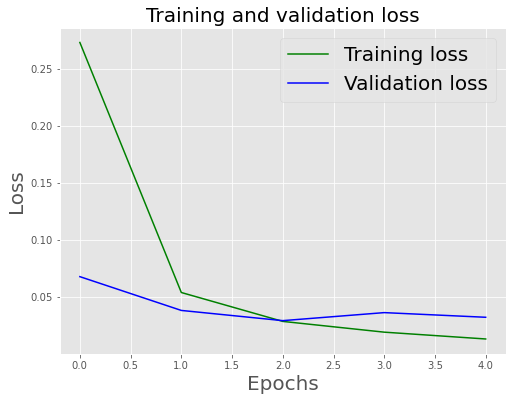

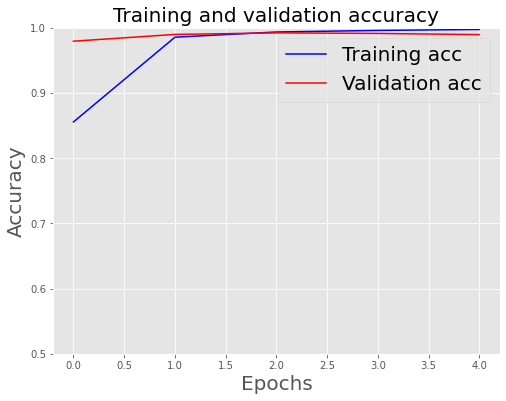

In [43]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [28]:
model.evaluate(X_test, y_test)
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))



11225/11225 [==============================] - 50s 4ms/sample - loss: 0.0383 - accuracy: 0.9881
Accuracy on testing set: 0.9880623608017818
Precision on testing set: 0.9848993288590604
Recall on testing set: 0.9900674662668666


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

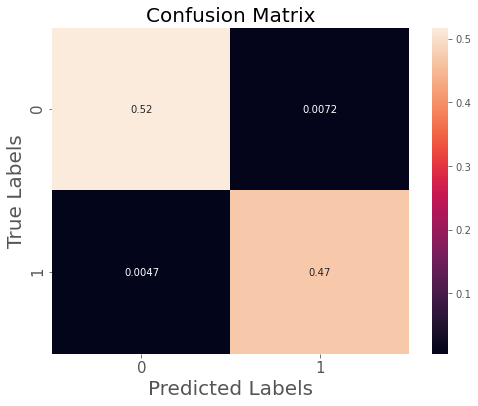

In [40]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5861
           1       0.99      0.98      0.99      5364

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [44]:
model.save('FakeNews_RNN.h5')